In [ ]:
import numpy as np
import pydot
from IPython.display import HTML, SVG, display
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    GenerateHtml,
    InverseDynamicsController,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    Parser,
    Simulator,
    StartMeshcat,
    RigidTransform,
    RollPitchYaw,
    PiecewisePolynomial,
    TrajectorySource
)

from manipulation import running_as_notebook

In [ ]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://7e656c9a-e35c-4740-b249-07fef330708d.deepnoteproject.com/7001/


# Unactuated simulation

In [ ]:
def animation_demo():
    builder = DiagramBuilder()

    # Adds both MultibodyPlant and the SceneGraph, and wires them together.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    # Note that we parse into both the plant and the scene_graph here.

    Parser(plant).AddModels("file:///work/cylinder.sdf", )
    #plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
    bed_transform = RigidTransform()
    bed_transform.set_rotation(RollPitchYaw(np.pi/2,0,0))
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("Rotator_Base"), bed_transform)
    plant.Finalize()

    # Adds the MeshcatVisualizer and wires it to the SceneGraph.
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)

    plant.SetPositions(plant_context, np.ones(1))


    simulator = Simulator(diagram, context)
    simulator.set_target_realtime_rate(1.0)

    meshcat.StartRecording()
    simulator.AdvanceTo(5.0 if running_as_notebook else 0.1)
    meshcat.StopRecording()
    meshcat.PublishRecording()


animation_demo()

# With Control - static

In [ ]:
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.

print_bed = Parser(plant).AddModels("file:///work/cylinder.sdf")[0]
#plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
bed_transform = RigidTransform()
bed_transform.set_rotation(RollPitchYaw(np.pi/2,0,0))
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("Rotator_Base"), bed_transform)
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

# Adds an approximation of the iiwa controller.
# TODO(russt): replace this with the joint impedance controller.
kp = [100] * plant.num_positions()
ki = [1] * plant.num_positions()
kd = [20] * plant.num_positions()
bed_controller = builder.AddSystem(
    InverseDynamicsController(plant, kp, ki, kd, False)
)
bed_controller.set_name("bed_controller")
builder.Connect(
    plant.get_state_output_port(print_bed),
    bed_controller.get_input_port_estimated_state(),
)
builder.Connect(
    bed_controller.get_output_port_control(), plant.get_actuation_input_port()
)
diagram = builder.Build()



diagram.set_name("with bed controller")

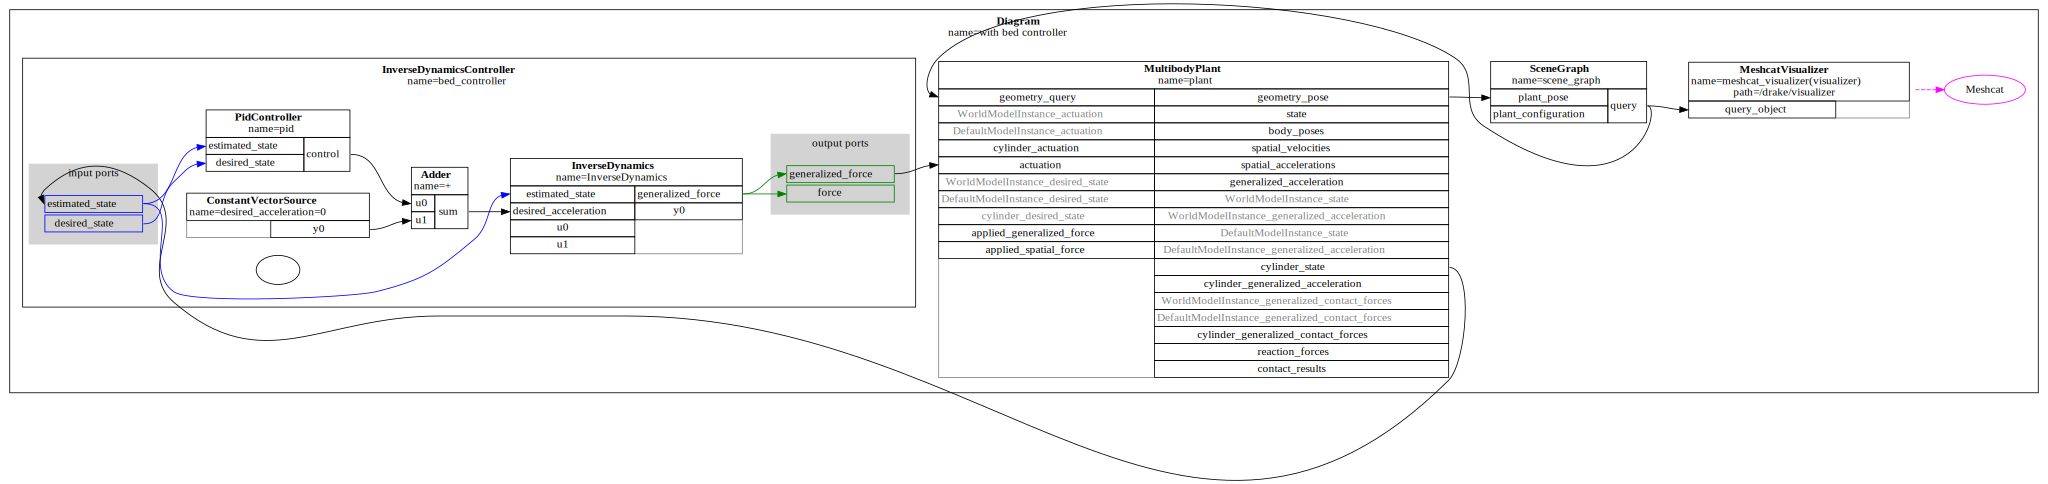

In [ ]:
SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())

In [ ]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
q0 = np.array([-0.1])
x0 = np.hstack((q0, -1 * q0))
plant.SetPositions(plant_context, q0)
bed_controller.GetInputPort("desired_state").FixValue(
    bed_controller.GetMyMutableContextFromRoot(context), x0
)
#print(context)

In [ ]:
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(3.0 if running_as_notebook else 0.1);

# Attempting path plan

In [ ]:
def BuildAndSimulateTrajectory(q_traj, duration=0.01):
    """Simulate trajectory for manipulation station.
    @param q_traj: Trajectory class used to initialize TrajectorySource for joints.
    """
    builder = DiagramBuilder()

    # Adds both MultibodyPlant and the SceneGraph, and wires them together.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    # Note that we parse into both the plant and the scene_graph here.

    print_bed = Parser(plant).AddModels("file:///work/cylinder.sdf")[0]
    #plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
    bed_transform = RigidTransform()
    bed_transform.set_rotation(RollPitchYaw(np.pi/2,0,0))
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("Rotator_Base"), bed_transform)

    plant.Finalize()


    """
    visualizer = MeshcatVisualizer.AddToBuilder(
        builder,
        station.GetOutputPort("query_object"),
        meshcat,
        MeshcatVisualizerParams(delete_on_initialization_event=False),
    )
    """
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    # Adds an approximation of the iiwa controller.
    # TODO(russt): replace this with the joint impedance controller.
    kp = [100] * plant.num_positions()
    ki = [1] * plant.num_positions()
    kd = [20] * plant.num_positions()
    bed_controller = builder.AddSystem(
        InverseDynamicsController(plant, kp, ki, kd, False)
    )
    

    bed_controller.set_name("bed_controller")
    builder.Connect(
        plant.get_state_output_port(print_bed),
        bed_controller.get_input_port_estimated_state(),
    )
    
    builder.Connect(
        bed_controller.get_output_port_control(), plant.get_actuation_input_port()
    )
    
    

    q_traj_system = builder.AddSystem(TrajectorySource(q_traj))
    
    builder.Connect(
        q_traj_system.get_output_port(), bed_controller.GetInputPort("desired_state")
    )
    

    diagram = builder.Build()
    diagram.set_name("with bed controller")

    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    bed = plant.GetModelInstanceByName("cylinder")
    plant.SetPositions(plant_context, bed, np.array([0.3]))

    simulator = Simulator(diagram, context)
    visualizer.StartRecording(False)
    simulator.AdvanceTo(duration)
    visualizer.PublishRecording()

    return simulator, plant

In [ ]:
def CreateDefaultContext(self):
        context = self.diagram.CreateDefaultContext()
        plant_context = self.diagram.GetMutableSubsystemContext(
            self.plant, context
        )

        # provide initial states
        q0 = np.array(
            [
                1.40666193e-05,
                1.56461165e-01,
                -3.82761069e-05,
                -1.32296976e00,
                -6.29097287e-06,
                1.61181157e00,
                -2.66900985e-05,
            ]
        )
        # set the joint positions of the kuka arm
        iiwa = self.plant.GetModelInstanceByName("iiwa")
        self.plant.SetPositions(plant_context, iiwa, q0)
        self.plant.SetVelocities(plant_context, iiwa, np.zeros(7))
        wsg = self.plant.GetModelInstanceByName("wsg")
        self.plant.SetPositions(plant_context, wsg, [-0.05, 0.05])
        self.plant.SetVelocities(plant_context, wsg, [0, 0])

        return context

In [ ]:
def create_q_knots(t_lst):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
    contain gripper joints, but these should not matter to the constraints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    q_knots = []
   
    for i in range(len(t_lst)):
        this_q = np.sin(t_lst[i]) + 0.5
        q_knots.append(np.array([this_q,this_q*0]))

    return q_knots

In [ ]:
t_lst = np.linspace(0, 11, 30)

q_knots = np.array(create_q_knots(t_lst))


q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots[:, 0:2].T)

simulator, station_plant = BuildAndSimulateTrajectory(q_traj, 11.0)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7e656c9a-e35c-4740-b249-07fef330708d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>